In [1]:
import simple_id
import torch
import os
import time
import gensim
import sys


from helpers import *

Previous work: [http://lstm.seas.harvard.edu/client/index.html](http://lstm.seas.harvard.edu/client/index.html)

Current interfaces:

[Word2Vec visual](http://shiny.reidmcy.com/int/)

[Records inspector](http://shiny.reidmcy.com/ntg/)

In [2]:
w2v = gensim.models.word2vec.Word2Vec.load('w2v/w2v.bin')
Net = torch.load(modelFname).cuda()

In [3]:
df_sample = pandas.read_csv('data/Other social sciences.csv', error_bad_lines = False)
df_sample.index = df_sample['wos_id']

In [4]:
row = df_sample.loc['WOS:000206783400002']

In [6]:
row_dict = dict(row)
row_dict['title_tokens'] = Tokens[row_dict['wos_id']][0]
row_dict['abstract_tokens'] = Tokens[row_dict['wos_id']][1]


row_dict['title_vecs'] = simple_id.genVecSeq(row_dict['title_tokens'], w2v)
row_dict['abstract_vecs'] = simple_id.genVecSeq(row_dict['abstract_tokens'], w2v)
row_dict['class'] = 1

In [7]:
predictionDict = Net.predictRow(row_dict)
predictionDict['wos_id'] = row['wos_id']
predictionDict['title'] = row['title']

In [8]:
predictionDict

{'weightP': tensor(1.1389, device='cuda:0'),
 'weightN': tensor(-0.9029, device='cuda:0'),
 'probPos': tensor(0.9645),
 'probNeg': tensor(0.1149),
 'prediction': 1,
 'wos_id': 'WOS:000206783400002',
 'title': 'An Agent-Based Spatially Explicit Epidemiological Model in MASON'}

(<Figure size 1440x1080 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a57b60d68>)

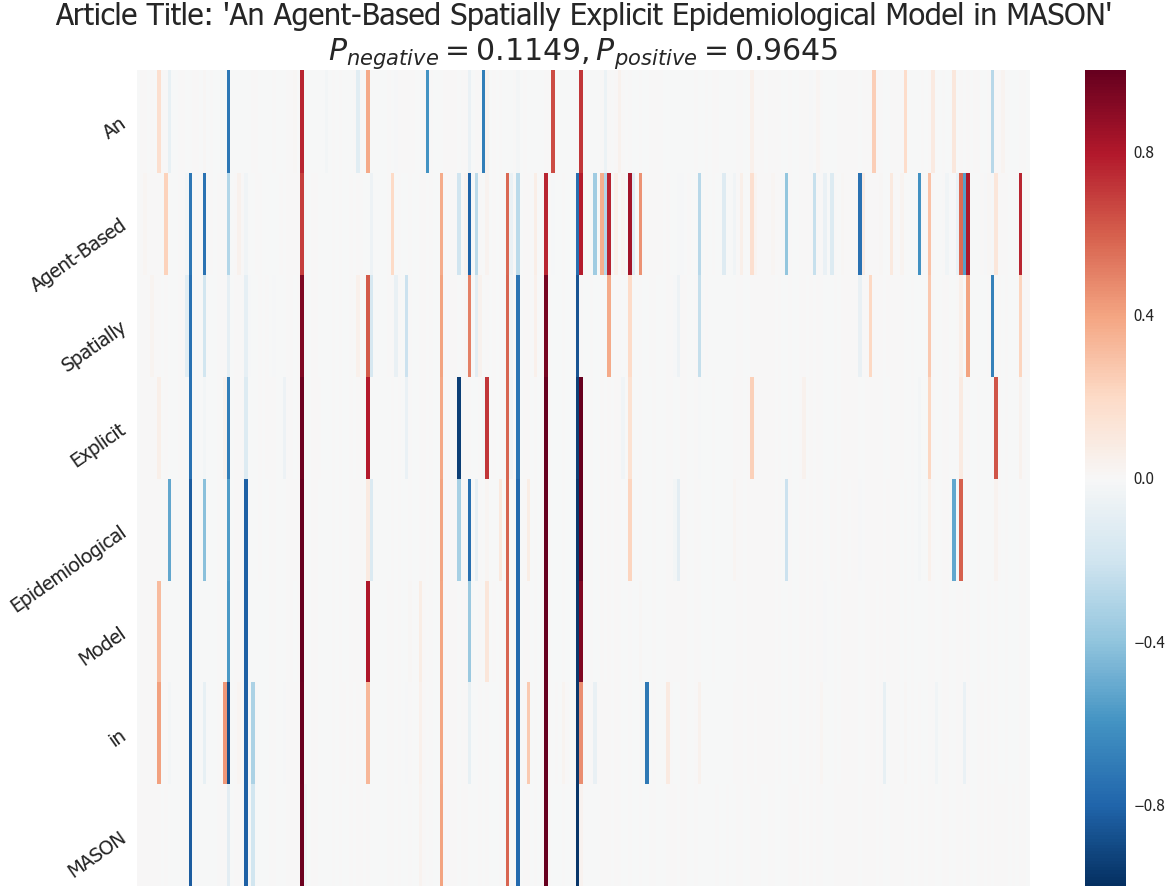

In [9]:
simple_id.compareRows([row_dict], Net)

In [10]:
row_dict['title_tokens']

['an',
 'agent-based',
 'spatially',
 'explicit',
 'epidemiological',
 'model',
 'in',
 'mason']

In [11]:
for i in range(len(row_dict['title_tokens'])):
    newDict = {
    'abstract' : row_dict['abstract'],
    'abstract_tokens' : row_dict['abstract_tokens'],
    #'title' : row_dict['title'],
    'title_tokens' : row_dict['title_tokens'][:i + 1],   
    }
    pred = Net.predictRow(newDict, w2v=w2v)
    print("propP is: {:.2f}% with title: '{}'".format(pred['probPos'] * 100, ' '.join(newDict['title_tokens'])))

propP is: 74.44% with title: 'an'
propP is: 97.52% with title: 'an agent-based'
propP is: 96.79% with title: 'an agent-based spatially'
propP is: 97.15% with title: 'an agent-based spatially explicit'
propP is: 96.01% with title: 'an agent-based spatially explicit epidemiological'
propP is: 96.46% with title: 'an agent-based spatially explicit epidemiological model'
propP is: 97.00% with title: 'an agent-based spatially explicit epidemiological model in'
propP is: 96.45% with title: 'an agent-based spatially explicit epidemiological model in mason'


In [12]:
for i in range(len(row_dict['abstract_tokens'])):
    newDict = {
    'abstract' : row_dict['abstract'],
    'abstract_tokens' : row_dict['abstract_tokens'][:i + 1],
    'title' : row_dict['title'],
    'title_tokens' : row_dict['title_tokens'],   
    }
    pred = Net.predictRow(newDict, w2v=w2v)
    print("propP is: {:.2f}% with abstract only {} sentences long".format(pred['probPos'] * 100, i + 1))

propP is: 95.96% with abstract only 1 sentences long
propP is: 95.39% with abstract only 2 sentences long
propP is: 94.61% with abstract only 3 sentences long
propP is: 96.45% with abstract only 4 sentences long


In [13]:
preds = []
for i in range(len(row_dict['title_tokens'])):
    predT = []
    for j in range(len(row_dict['abstract_tokens'])):
        newDict = {
            'abstract_tokens' : row_dict['abstract_tokens'][:j+1],
            'title_tokens' : row_dict['title_tokens'][:i + 1],   
            }
        #import pdb; pdb.set_trace()
        pred = Net.predictRow(newDict, w2v=w2v)
        predT.append(float(pred['probPos']))
    preds.append(predT)

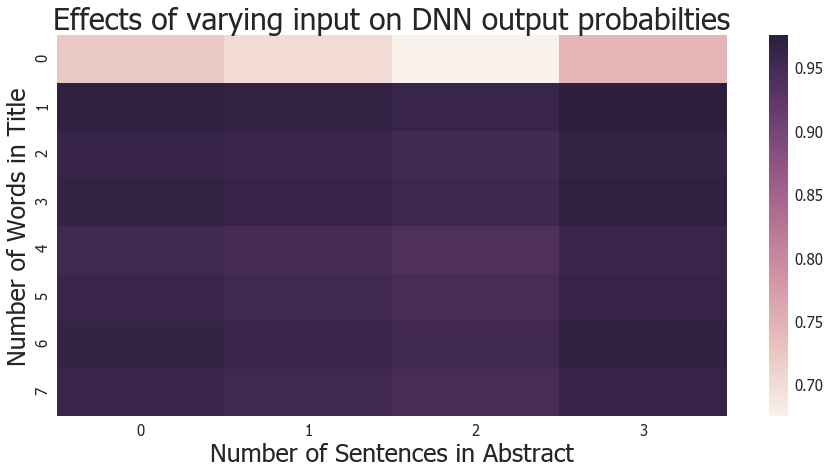

In [14]:
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(preds, ax = ax)
ax.set_ylabel('Number of Words in Title')
ax.set_xlabel('Number of Sentences in Abstract')
ax.set_title("Effects of varying input on DNN output probabilties");

In [15]:
preds = []
for i in range(len(row_dict['title_tokens'])):
    predT = []
    for j in range(len(row_dict['abstract_tokens'])):
        for k in range(len(row_dict['abstract_tokens'][j])):
            newDict = {
                'abstract_tokens' : row_dict['abstract_tokens'][:j] + [row_dict['abstract_tokens'][j][:k+1]],
                'title_tokens' : row_dict['title_tokens'][:i + 1],   
                }
            pred = Net.predictRow(newDict, w2v=w2v)
            predT.append(float(pred['probPos']))
    print("{:.0f}% done".format(i / len(row_dict['title_tokens']) * 100), end = '\r')
    preds.append(predT)

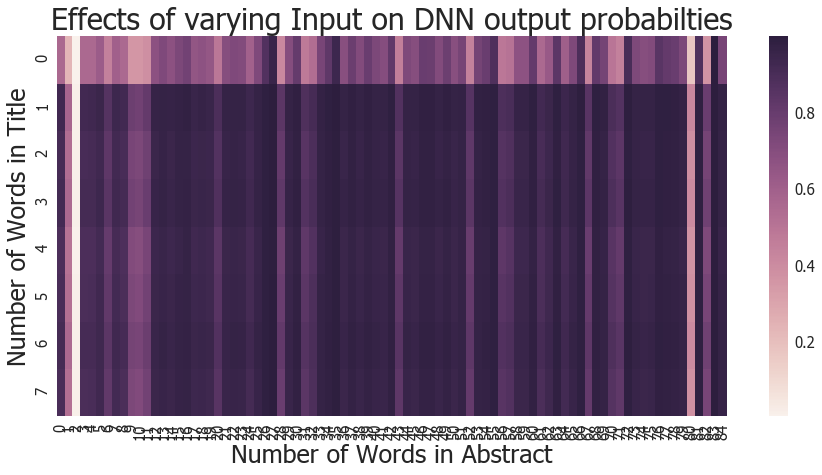

In [16]:
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(preds, ax = ax)
ax.set_ylabel('Number of Words in Title')
ax.set_xlabel('Number of Words in Abstract')
ax.set_title("Effects of varying Input on DNN output probabilties");

In [18]:
def makeVaryingArray(wos_id):
    row = df_sample.loc[wos_id]
    row_dict = dict(row)
    row_dict['title_tokens'] = Tokens[row_dict['wos_id']][0]
    row_dict['abstract_tokens'] = Tokens[row_dict['wos_id']][1]
    preds = []
    for i in range(len(row_dict['title_tokens'])):
        predT = []
        for j in range(len(row_dict['abstract_tokens'])):
            newDict = {
                'abstract_tokens' : row_dict['abstract_tokens'][:j+1],
                'title_tokens' : row_dict['title_tokens'][:i + 1],   
                }
            #import pdb; pdb.set_trace()
            pred = Net.predictRow(newDict, w2v=w2v)
            predT.append(float(pred['probPos']))
        preds.append(predT)
    return preds

An Agent-Based Spatially Explicit Epidemiological Model in MASON
On the Simulation of Global Reputation Systems
Simulating the Emergence of Task Rotation
The AtollGame Experience: from Knowledge Engineering to a Computer-Assisted Role Playing Game
Uncertainty and Cooperation: Analytical Results and a Simulated Agent Society
Emancipation or workability? Critical versus pragmatic scientific orientation in action research
Speaking for ourselves A Colombia-Canada research collaboration
Active research towards the addressal of HIV/AIDS in the informal economy in Zambia Recognition of complicity in unfolding situations
Research for change Outcome mapping's contribution to emancipatory action research in Africa
Action research and social development in China Creating synergy between marginalized populations and government officials


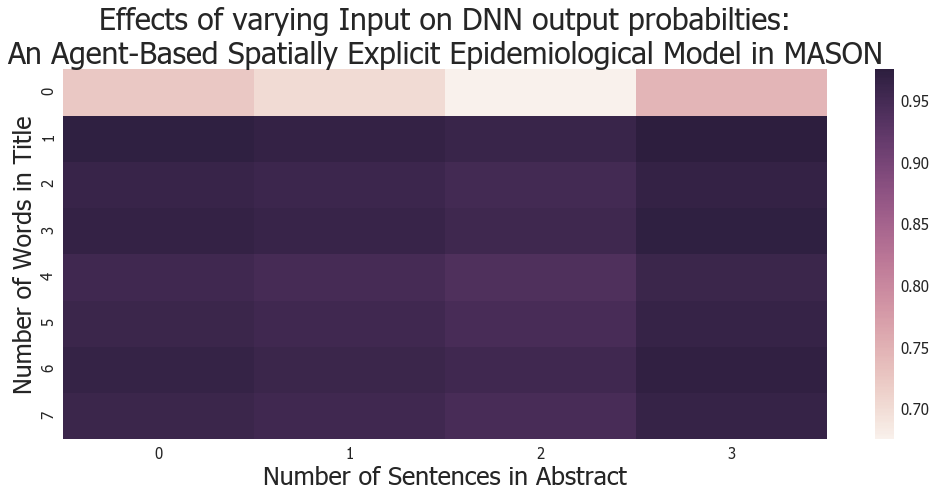

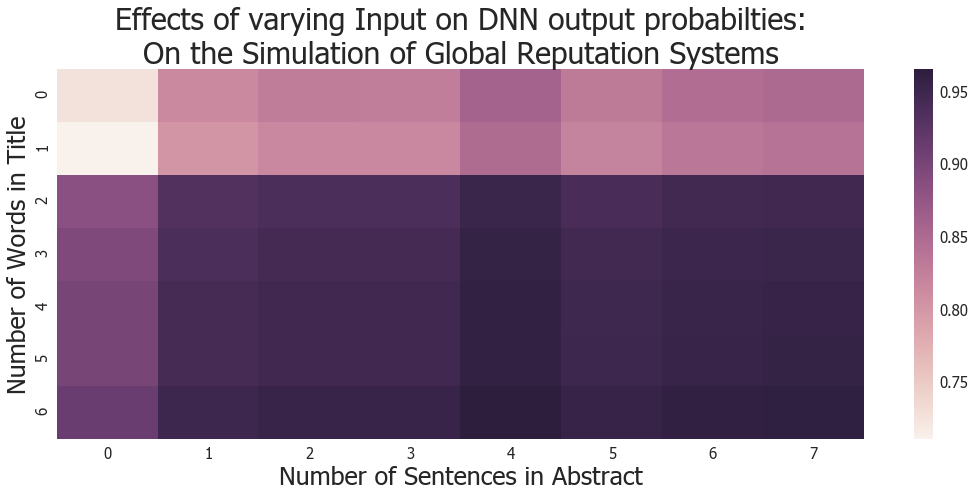

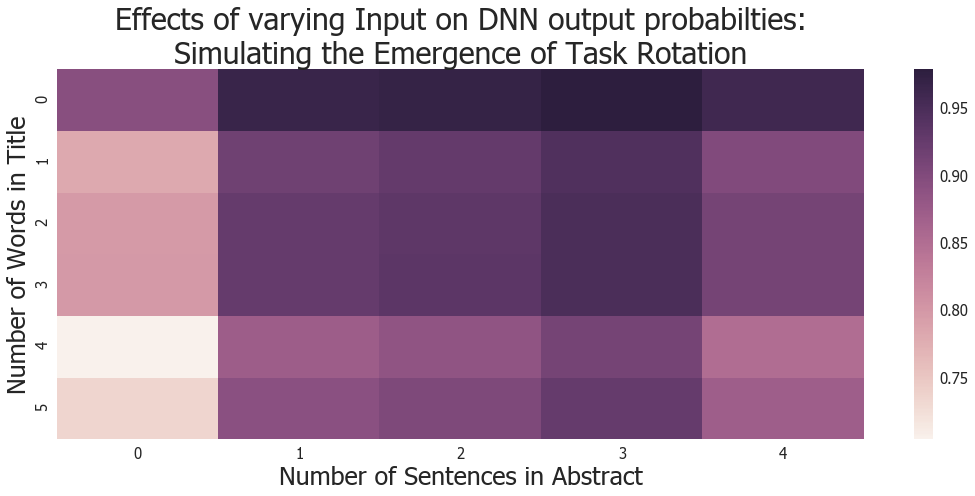

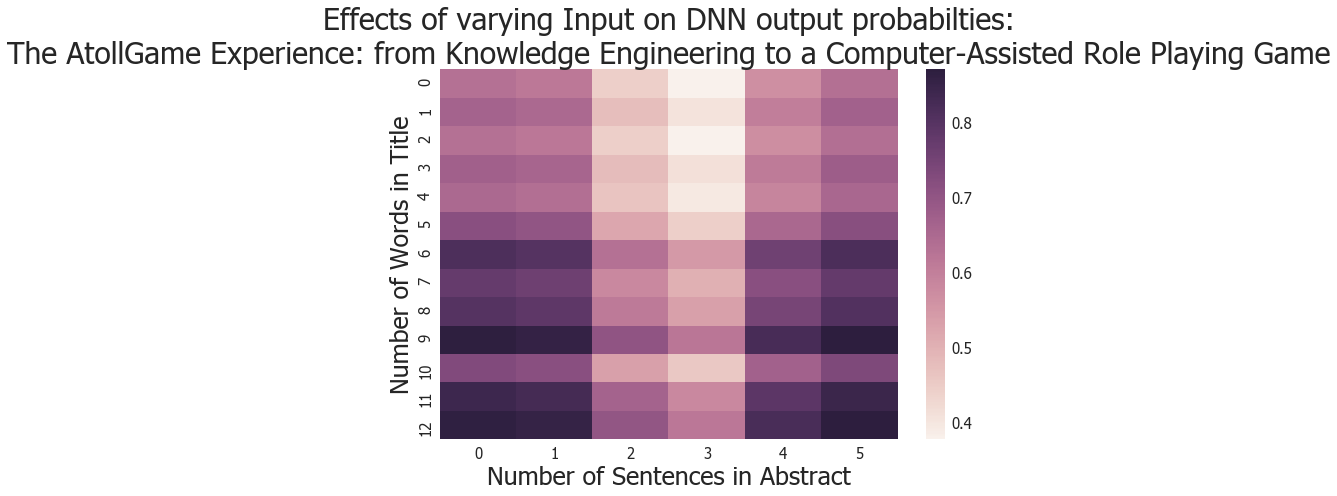

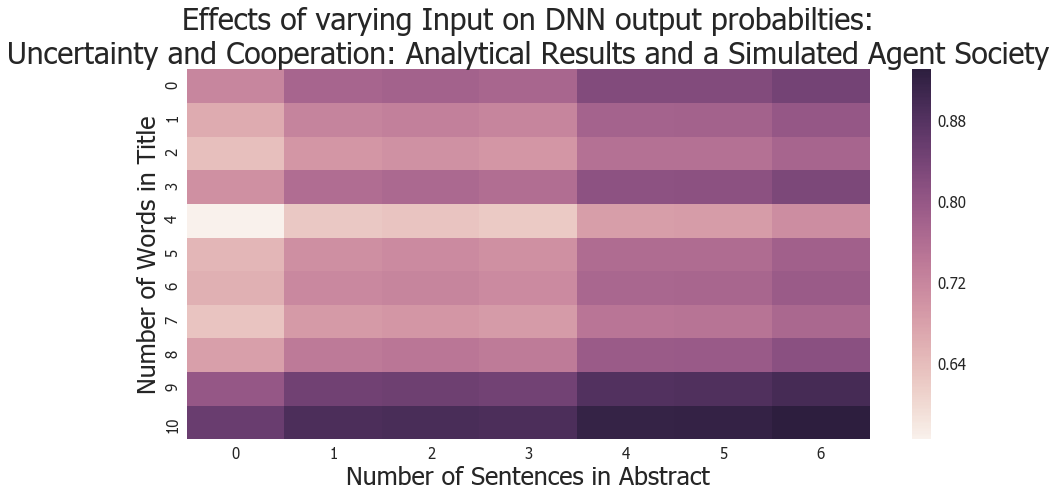

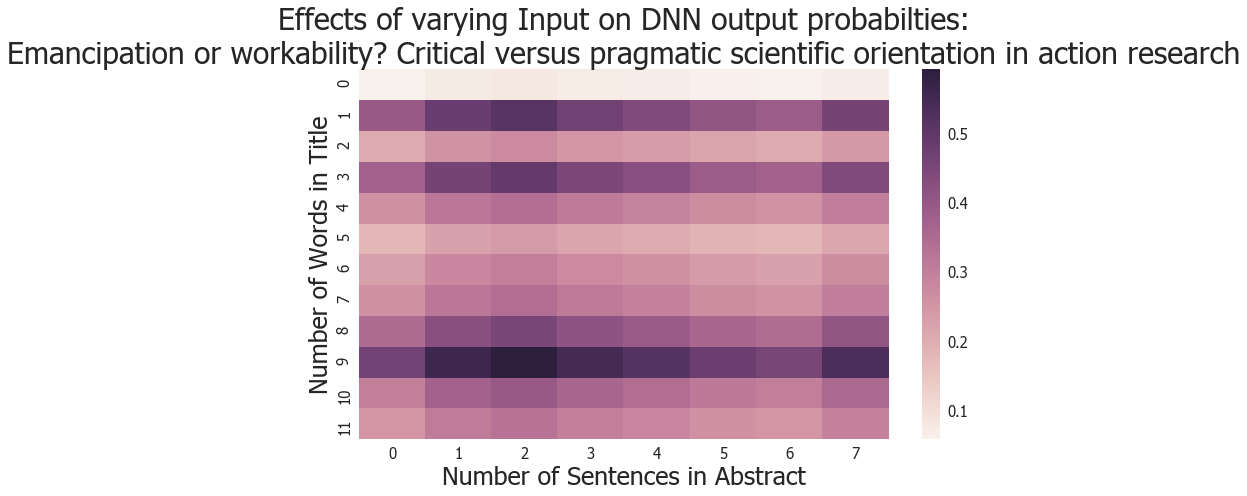

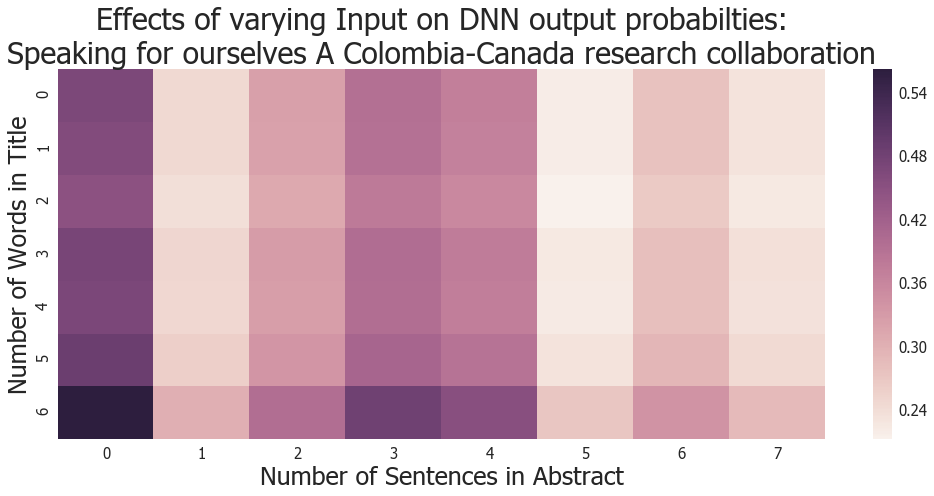

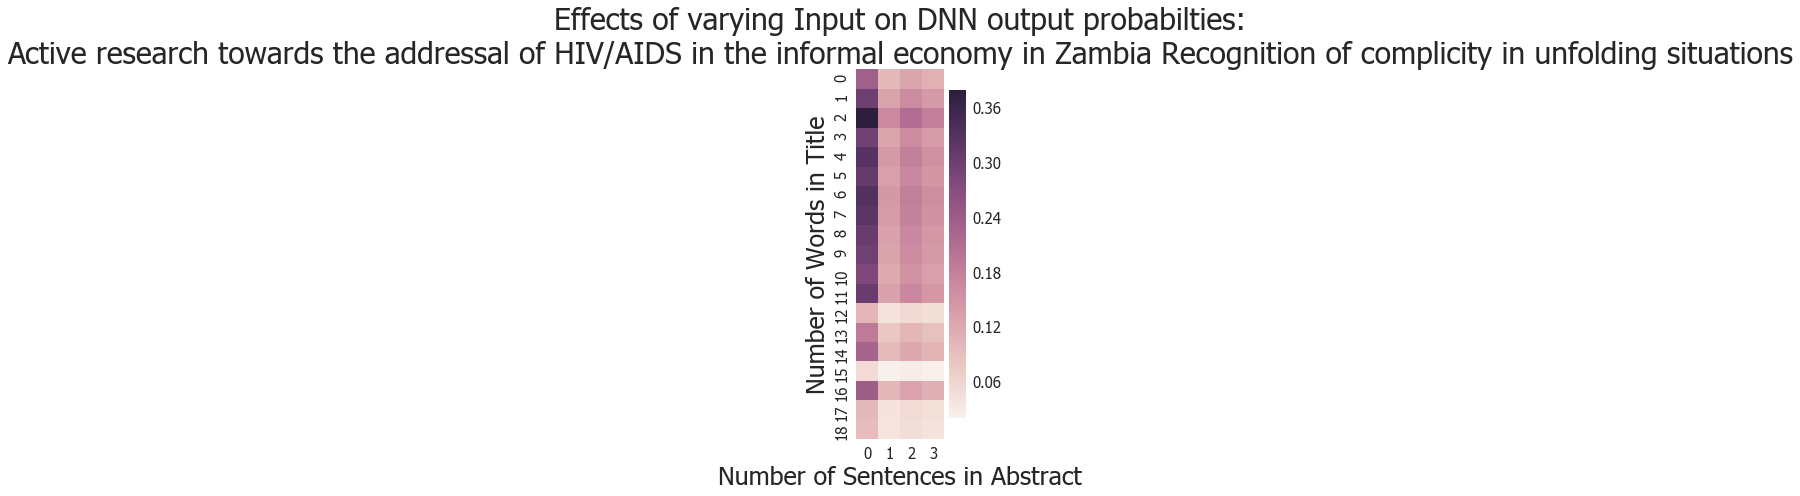

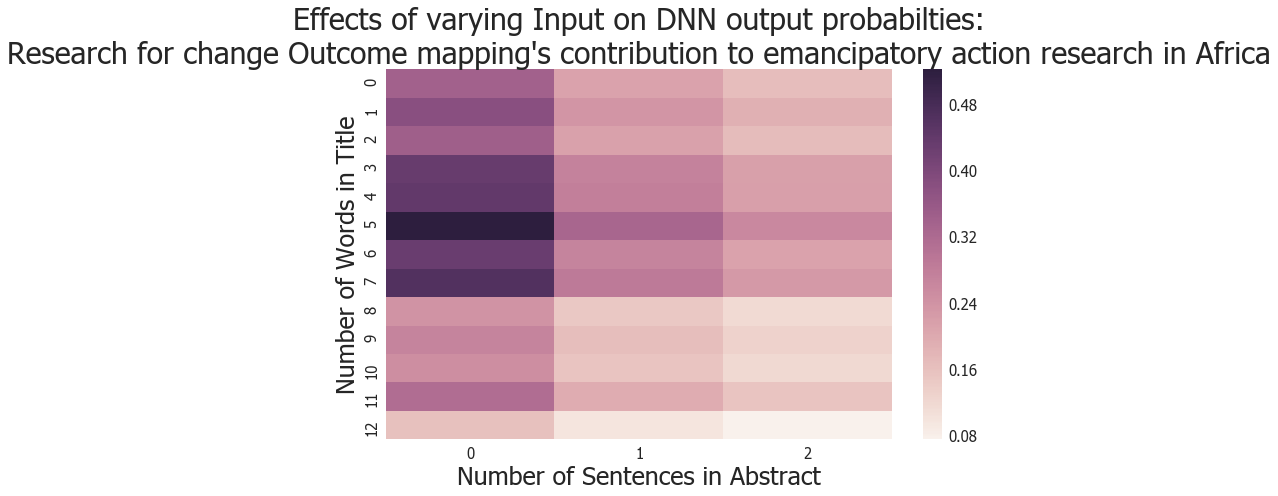

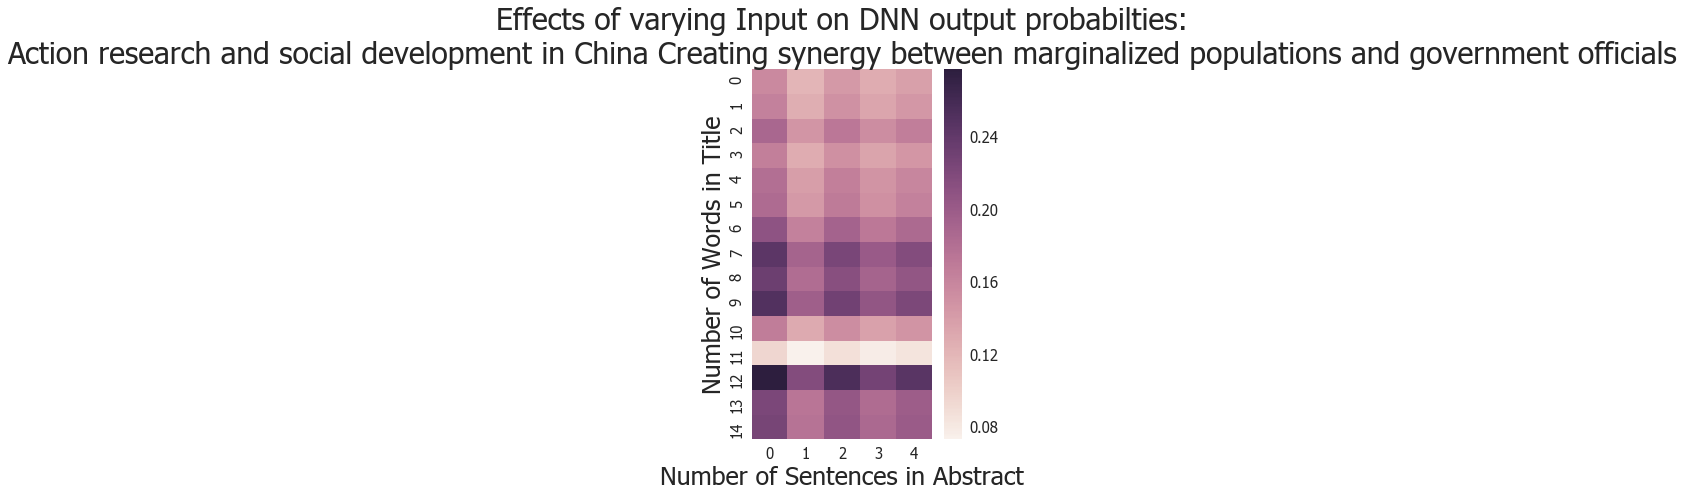

In [29]:
for i, row in df_sample.iloc[:5].iterrows():
    print(row['title'])
    predA = makeVaryingArray(row['wos_id'])
    fig, ax = plt.subplots(figsize = (15, 7))
    seaborn.heatmap(predA, ax = ax)
    ax.set_ylabel('Number of Words in Title')
    ax.set_xlabel('Number of Sentences in Abstract')
    ax.set_title("Effects of varying Input on DNN output probabilties:\n{}".format(row['title']))
    fig.tight_layout()
    plt.savefig('images/pred_var_{}.pdf'.format(row['title'][:50].replace(' ', '_')), format = 'pdf')
    
for i, row in df_sample.iloc[-5:].iterrows():
    print(row['title'])
    predA = makeVaryingArray(row['wos_id'])
    fig, ax = plt.subplots(figsize = (15, 7))
    seaborn.heatmap(predA, ax = ax)
    ax.set_ylabel('Number of Words in Title')
    ax.set_xlabel('Number of Sentences in Abstract')
    ax.set_title("Effects of varying Input on DNN output probabilties:\n{}".format(row['title']))
    fig.tight_layout()
    plt.savefig('images/pred_var_{}.pdf'.format(row['title'][:50].replace(' ', '_').replace('/', '')), format = 'pdf')

In [22]:
df_sample.iloc[:5]

,wos_id,prediction,probNeg,probPos,weightN,weightP,id,wos_id.1,doi,source,...,Psychology,Social and economic geography,Sociology,prediction_partial,probNeg_partial,probPos_partial,weightN_partial,weightP_partial,pred,pred_part
wos_id,,,,,,,,,,,,,,,,,,,,,
WOS:000206783400002,WOS:000206783400002,1,0.114884,0.964524,-0.902853,1.138939,50763694,WOS:000206783400002,NaN,JASSS-THE JOURNAL OF ARTIFICIAL SOCIETIES AND ...,...,False,False,False,1,0.098266,0.966493,-1.174805,1.041841,Computational,Computational
WOS:000206783400003,WOS:000206783400003,1,0.118061,0.962201,-0.910524,1.100392,51201688,WOS:000206783400003,NaN,JASSS-THE JOURNAL OF ARTIFICIAL SOCIETIES AND ...,...,False,False,False,1,0.046893,0.989113,-1.562499,1.449362,Computational,Computational
WOS:000206783400004,WOS:000206783400004,1,0.261668,0.871330,-0.465231,0.572087,51388289,WOS:000206783400004,NaN,JASSS-THE JOURNAL OF ARTIFICIAL SOCIETIES AND ...,...,False,False,False,1,0.516635,0.638054,-0.026924,-0.093490,Computational,Computational
WOS:000206783400005,WOS:000206783400005,1,0.261918,0.869795,-0.476604,0.559420,51418608,WOS:000206783400005,NaN,JASSS-THE JOURNAL OF ARTIFICIAL SOCIETIES AND ...,...,False,False,False,1,0.120026,0.956370,-1.024832,0.967356,Computational,Computational
WOS:000206783400006,WOS:000206783400006,1,0.176193,0.931029,-0.675933,0.866427,50717471,WOS:000206783400006,NaN,JASSS-THE JOURNAL OF ARTIFICIAL SOCIETIES AND ...,...,False,False,False,1,0.049463,0.988310,-1.525084,1.430716,Computational,Computational


# Next steps

+ Get interface with R setup
+ Make interactive
+ Add real explanations
+ Maybe add more modes

Is it truthful?

Is it functional?

Is it beautiful?

Is it insightful?

Is it enlightening?